In [ ]:
# Checkout www.pygimli.org for more examples


# Regularization - concepts explained

In geophysical inversion, we minimize the data objective functional as
the L2 norm of the misfit between data $d$ and the forward
response $f(m)$ of the model $m$, weighted by the data error
$\epsilon$:

\begin{align}\Phi_d = \sum\limits_i^N \left(\frac{d_i-f_i(m)}{\epsilon_i}\right)^2=\|W_d(d-f(m))\|^2\end{align}

As this minimization problem is non-unique and ill-posed, we introduce a
regularization term $\Phi$, weighted by a regularization parameter
$\lambda$:

\begin{align}\Phi = \Phi_d + \lambda \Phi_m\end{align}

The regularization strength $\lambda$ should be chosen so that the
data are fitted within noise, i.e. $\chi^2=\Phi_d/N=1$.

In the term $\Phi-m$ we put our expectations to the model, e.g. to
be close to any prior model. In many cases we do not have much
information and aim for the smoothest model that is able to fit our
data. We decribe it by the operator $W_m$:

\begin{align}\Phi_m=\|W_m (m-m_{ref})\|^2\end{align}

The regularization operator is defined by some constraint operator
$C$ weighted by some weighting function $w$ so that
$W_m=\mbox{diag}(w) C$. The operator $C$ can be a discrete
smoothness operator, or the identity to keep the model close to the
reference model $m_{ref}$.


We start with importing the numpy, matplotlib and pygimli libraries




In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.viewer import showMesh # import a function

Regularization drives the model where the data are too weak to constrain
the model. In order to explain different kinds of regularization (also
called constraints), we use a very simple mapping forward operator: The
values at certain positions are picked.




In [2]:
from pygimli.frameworks import PriorModelling

Implementation 1. determine the indices where the cells are

::

   ind = [mesh.findCell(po).id() for po in pos]

2. forward response: take the model at indices

::

   response = model[ind]

3. Jacobian matrix

::

   J = pg.SparseMapMatrix()
   J.resize(len(ind), mesh.cellCount())
   for i, n in enumerate(self.ind):
       self.J.setVal(i, n, 1.0)




We exemplify this on behalf of a simple triangular mesh in a rectangular
domain.




Mesh: Nodes: 377 Cells: 684 Boundaries: 1060


(<Axes: >, None)

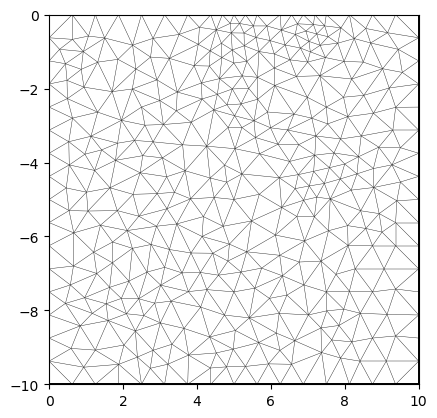

In [24]:
rect = mt.createRectangle(start=[0, -10], end=[10, 0])
mesh = mt.createMesh(rect, quality=34.5, area=0.3)
print(mesh)
pg.show(mesh)

We define two positions where we associate two arbitrary values.




18/04/24 - 11:16:27 - pyGIMLi - INFO - Found 1 regions.


(<Axes: >, None)

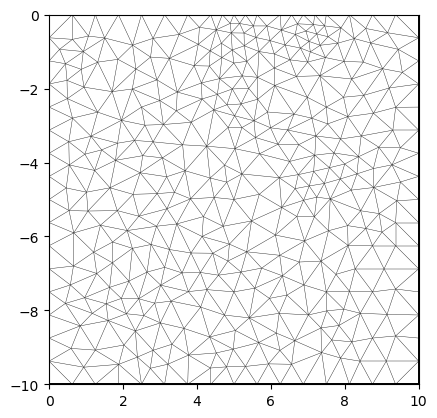

In [25]:
pos = [[3, -3], [7, -7]]
vals = np.array([20., 15.])
fop = PriorModelling(mesh, pos)
pg.show(mesh)

We set up an inversion instance with the forward operator and prepare
the keywords for running the inversion always the same way: - the data
vector - the error vector (as relative error) - a starting model value
(could also be vector)




In [26]:
inv = pg.Inversion(fop=fop, verbose=False)
# invkw = dict(dataVals=vals, errorVals=np.ones_like(vals)*0.03, startModel=12)
invkw = dict(dataVals=vals, relativeError=0.03, startModel=12, lam=200)
plotkw = dict(cMap="Spectral_r", coverage=1, cMin=14, cMax=21)

## Classical smoothness constraints




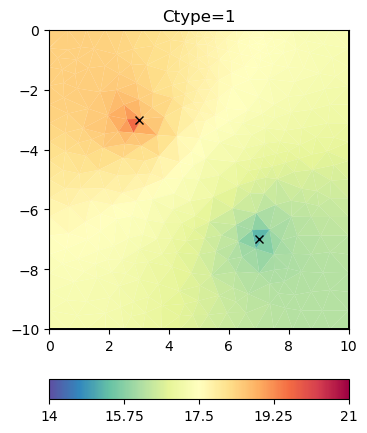

In [27]:
inv.setRegularization(cType=1)  # the default
result = inv.run(**invkw)
ax, _ = pg.show(mesh, result, **plotkw)
ax.plot(pg.x(pos), pg.y(pos), "kx")

t = ax.set_title("Ctype=1")

We will have a closer look at the regularization matrix $C$`.




992 684 Mesh: Nodes: 377 Cells: 684 Boundaries: 1060
[ 48 116] 2 [1.0, -1.0]


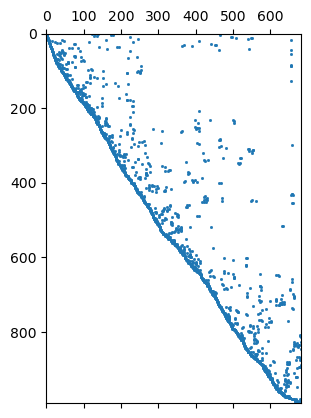

In [28]:
C = fop.constraints()
print(C.rows(), C.cols(), mesh)
ax, _ = pg.show(fop.constraints(), markersize=1)

row = C.row(111)
nz = np.nonzero(row)[0]
print(nz, row[nz])

How does that change the regularization matrix $C$?






0.19999999999999996 1.0


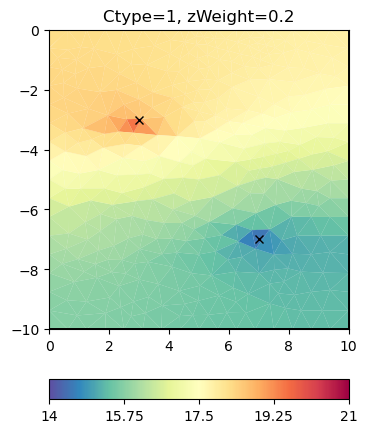

In [29]:
inv.setRegularization(cType=1, zWeight=0.2)  # the default
result = inv.run(**invkw)
ax, _ = pg.show(mesh, result, **plotkw)
ax.plot(pg.x(pos), pg.y(pos), "kx")
t = ax.set_title("Ctype=1, zWeight=0.2")

RM = fop.regionManager()
cw = RM.constraintWeights()
print(min(cw), max(cw))

Now we try some other regularization options.




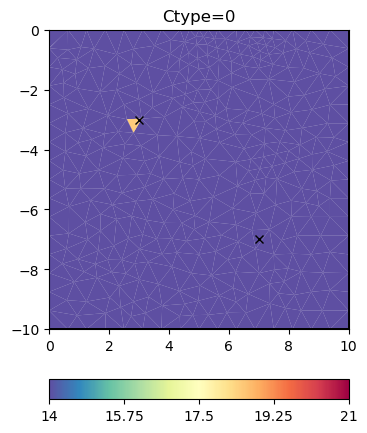

In [30]:
inv.setRegularization(cType=0)  # damping of the model
result = inv.run(**invkw)
ax, _ = pg.show(mesh, result, **plotkw)
ax.plot(pg.x(pos), pg.y(pos), "kx")
t = ax.set_title("Ctype=0")

Obviously, the damping keeps the model small (log 1=0) as the
starting model is NOT a reference model by default.
We enable this by specifying the `isReference` switch.




18/04/24 - 11:31:17 - pyGIMLi - INFO - Setting starting model as reference!


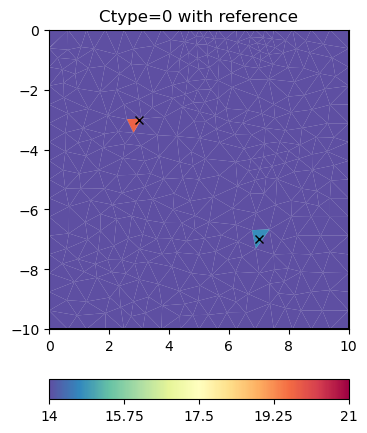

In [31]:
invkw["isReference"] = True
result = inv.run(**invkw)
ax, cb = pg.show(mesh, result, **plotkw)
ax.plot(pg.x(pos), pg.y(pos), "kx")
t = ax.set_title("Ctype=0 with reference")

``cType=10`` means a mix between 1st order smoothness (1) and damping (0)




18/04/24 - 11:40:28 - pyGIMLi - INFO - Setting starting model as reference!


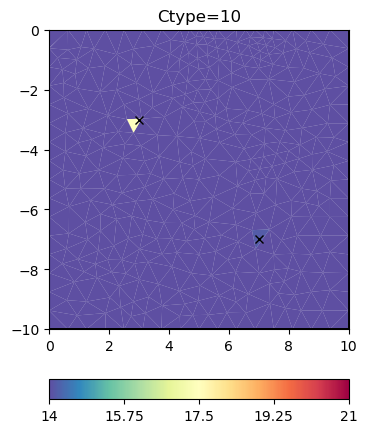

In [32]:
inv.setRegularization(cType=10)  # mix of 1st order smoothing and damping
result = inv.run(**invkw)
ax, _ = pg.show(mesh, result, **plotkw)
ax.plot(pg.x(pos), pg.y(pos), "kx")
t = ax.set_title("Ctype=10")

In the matrix both contributions are under each other




1676 684
Mesh: Nodes: 377 Cells: 684 Boundaries: 1060


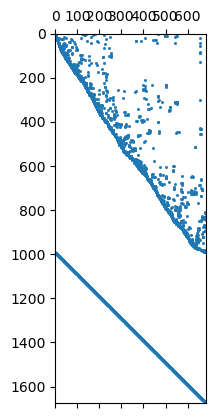

In [33]:
C = fop.constraints()
print(C.rows(), C.cols())
print(mesh)
ax, _ = pg.show(fop.constraints(), markersize=1)

We see that we have the first order smoothness and the identity matrix
below each other. We can also use a second-order (-1 2 -1) smoothness
operator by ``cType=2``.




18/04/24 - 11:41:26 - pyGIMLi - INFO - Setting starting model as reference!


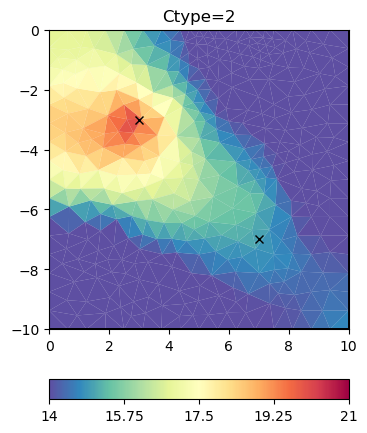

In [34]:
inv.setRegularization(cType=2)  # 2nd order smoothing
result = inv.run(**invkw)
ax, _ = pg.show(mesh, result, **plotkw)
ax.plot(pg.x(pos), pg.y(pos), "kx")
t = ax.set_title("Ctype=2")

We have a closer look at the constraints matrix




684 684 Mesh: Nodes: 377 Cells: 684 Boundaries: 1060


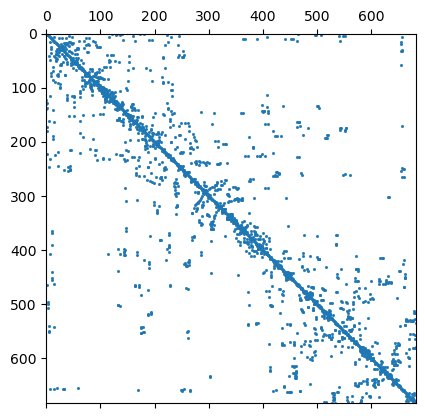

In [35]:
C = fop.constraints()
print(C.rows(), C.cols(), mesh)
ax, _ = pg.show(C, markersize=1)

It looks like a Laplace operator and seems to have a wider range
compared to first-order smoothness.




## Geostatistical regularization




The idea is that not only neighbors are correlated to each other but to
have a wider correlation by using an operator

More details can be found in
https://www.pygimli.org/_tutorials_auto/3_inversion/plot_6-geostatConstraints.html




## Application
We can pass the correlation length directly to the inversion instance




11/04/24 - 16:36:52 - pyGIMLi - INFO - Setting starting model as reference!
11/04/24 - 16:36:52 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 1 with: I=[2, 2], dip=0, strike=0
11/04/24 - 16:36:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
11/04/24 - 16:36:52 - pyGIMLi - INFO - (C) Time for eigenvalue decomposition 0.3s
11/04/24 - 16:36:52 - pyGIMLi - INFO - Cache stored: C:\Users\matthew.noteboom\AppData\Roaming\pygimli\Cache\3430426147639925957


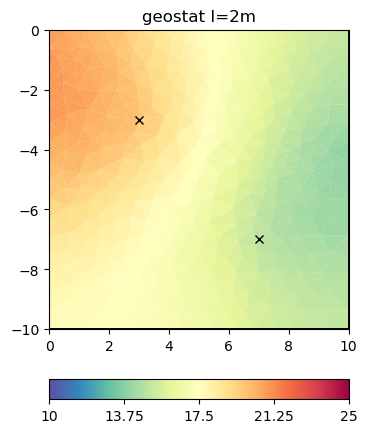

In [15]:
inv.setRegularization(correlationLengths=[2, 2])
result = inv.run(**invkw)
ax, _ = pg.show(mesh, result, **plotkw)
ax.plot(pg.x(pos), pg.y(pos), "kx")
t = ax.set_title("geostat I=2m")

This look structurally similar to the second-order smoothness, but can
drive values outside the expected range in regions of no data coverage.
We change the correlation lengths and the dip to be inclining




11/04/24 - 16:37:05 - pyGIMLi - INFO - Setting starting model as reference!
11/04/24 - 16:37:05 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 1 with: I=[2, 0.5, 2], dip=-20, strike=0
11/04/24 - 16:37:05 - pyGIMLi - INFO - (C) Time for eigenvalue decomposition 0.2s
11/04/24 - 16:37:05 - pyGIMLi - INFO - Cache stored: C:\Users\matthew.noteboom\AppData\Roaming\pygimli\Cache\8079617641097683160


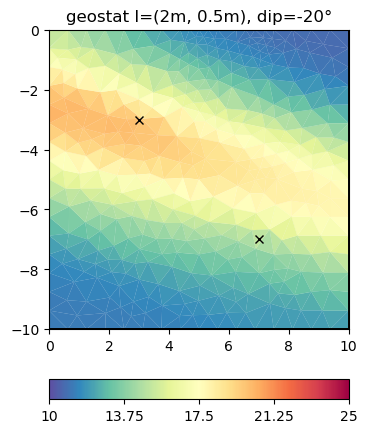

In [16]:
inv.setRegularization(correlationLengths=[2, 0.5, 2], dip=-20)
result = inv.run(**invkw)
ax, _ = pg.show(mesh, result, **plotkw)
ax.plot(pg.x(pos), pg.y(pos), "kx")
t = ax.set_title("geostat I=(2m, 0.5m), dip=-20°")

We now add many more points.




In [17]:
np.random.seed(42) # reproducabilty is our friend
N = 30
x = np.random.rand(N) * 10
y = -np.random.rand(N) * 10
v = np.random.rand(N) * 10 + 10

and repeat the above computations




11/04/24 - 16:37:18 - pyGIMLi - INFO - Found 1 regions.
11/04/24 - 16:37:18 - pyGIMLi - INFO - Starting inversion.
11/04/24 - 16:37:18 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 1 with: I=[4, 4], dip=0, strike=0
11/04/24 - 16:37:18 - pyGIMLi - INFO - Creating forward mesh from region infos.


fop: <pygimli.frameworks.modelling.PriorModelling object at 0x0000028AACFB64D0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000028AAD4D23B0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000028AAD4D2880>
min/max (data): 10.06/19.87
min/max (error): 3%/3%
min/max (start model): 10/10
--------------------------------------------------------------------------------


11/04/24 - 16:37:18 - pyGIMLi - INFO - (C) Time for eigenvalue decomposition 0.2s
11/04/24 - 16:37:18 - pyGIMLi - INFO - Cache stored: C:\Users\matthew.noteboom\AppData\Roaming\pygimli\Cache\8907906133366391510


inv.iter 0 ... chi² =  121.32
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    4.70 (dPhi = 95.29%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    3.00 (dPhi = 28.66%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    3.00 (dPhi = 0.02%) lam: 10.0
################################################################################
#                Abort criterion reached: dPhi = 0.02 (< 2.0%)                 #
################################################################################


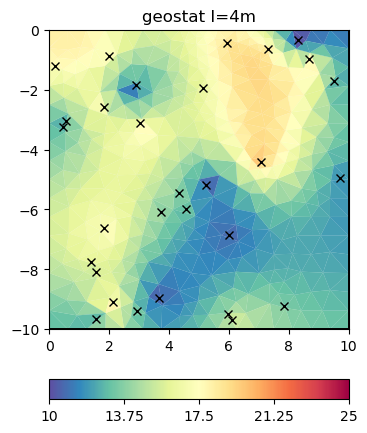

In [18]:
pos = [pg.Pos(xi, yi) for xi, yi in zip(x, y)]
fop = PriorModelling(mesh, pos)
inv = pg.Inversion(fop=fop, verbose=True)
inv.setRegularization(correlationLengths=[4, 4])
result = inv.run(v, relativeError=0.03, startModel=10, lam=10)
ax, _ = pg.show(mesh, result, **plotkw)
out = ax.plot(x, y, "kx")
t = ax.set_title("geostat I=4m")

Comparing the data with the model response is always a good idea.




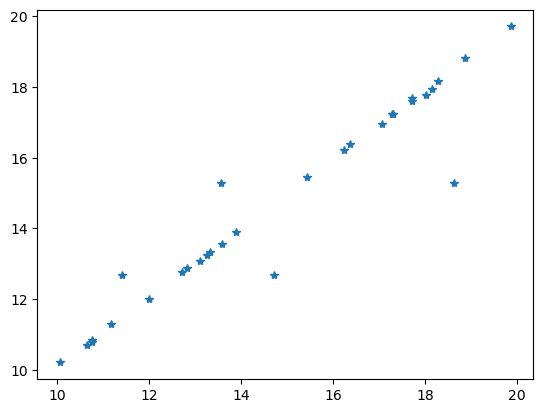

In [19]:
out = plt.plot(v, inv.response, "*")

## Individual regularization operators

Say you want to combine geostatistic operators with a damping, you can
create a block matrix pasting the matric vertically.




11/04/24 - 16:37:51 - pyGIMLi - INFO - Cache C:\Users\matthew.noteboom\.conda\envs\pg\lib\site-packages\pygimli\math\matrix.py:createCm05 restored (0.2s x 1): C:\Users\matthew.noteboom\AppData\Roaming\pygimli\Cache\8079617641097683160


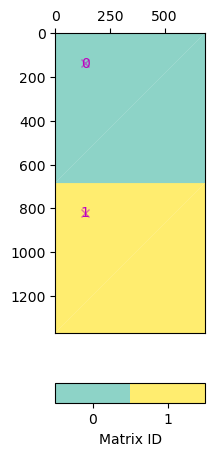

In [20]:
C = pg.matrix.BlockMatrix()
G = pg.matrix.GeostatisticConstraintsMatrix(mesh=mesh, I=[2, 0.5], dip=-20)
I1 = pg.matrix.IdentityMatrix(mesh.cellCount(), val=0.1)
C.addMatrix(G, 0, 0)
C.addMatrix(I1, mesh.cellCount(), 0)  # shifted down by number of cells
ax, _ = pg.show(C)

Note that in `pg.matrix` you find a lot of matrices and matrix generators.

We set this matrix directly and do the inversion.




11/04/24 - 16:37:56 - pyGIMLi - INFO - Starting inversion.
11/04/24 - 16:37:56 - pyGIMLi - INFO - Setting starting model as reference!


fop: <pygimli.frameworks.modelling.PriorModelling object at 0x0000028AACFB64D0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000028AAD4D3290>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000028AAD4D3220>
min/max (data): 10.06/19.87
min/max (error): 3%/3%
min/max (start model): 17/17
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  108.82
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    5.32 (dPhi = 94.94%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    2.97 (dPhi = 41.41%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.96 (dPhi = 0.11%) lam: 10.0
################################################################################
#                Abort criterion reached: dPhi = 0.11 (< 2.0%) 

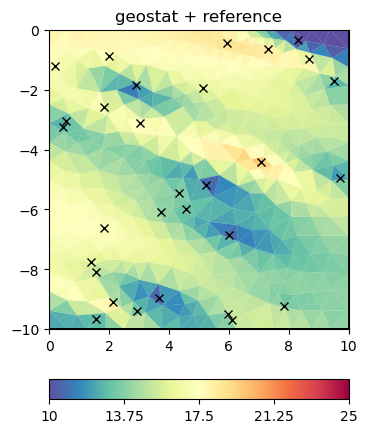

In [21]:
fop.setConstraints(C)
result = inv.run(v, relativeError=0.03, startModel=17, isReference=1, lam=10)
ax, _ = pg.show(mesh, result, **plotkw)
out = ax.plot(x, y, "kx")
t = ax.set_title("geostat + reference")

If you are using a method manager, you access the inversion instance by
`mgr.inv` and the forward operator by `mgr.fop`.




<div class="alert alert-info"><h4>Note</h4><p>Take-away messages

   -  regularization drives the model where data are weak
   -  think and play with your assumptions to the model
   -  there are several predefined options
   -  geostatistical regularization can be superior, because:
      -  it is mesh-independent
      -  it better fills the data gaps (e.g. 3D inversion of 2D profiles)</p></div>


